## 1. Análise Exploratória

In [1]:
#Bibliotecas a serem instaladas, se necessário
#!pip install numpy
#!pip install pandas
#!pip install joblib
#!pip install scikit-learn
#!pip install scipy
#!pip install matplotlib
#!pip install missingno
#!pip install category_encoders
#!pip install imblearn

In [4]:
#Bibliotecas a serem importadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import statsmodels.api as sm
from scipy import stats

import sklearn
from sklearn import datasets, linear_model, metrics, preprocessing, svm
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier

import category_encoders as ce

from collections import Counter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE

In [5]:
# Carregando a base
df = pd.read_csv('BRAZIL_CITIES.csv', 
                 encoding='ansi')

# Mostrando 5 primeiras linhas
df.head()

,CITY,STATE,IBGE_ID,CAPITAL,IBGE_RES_POP_ESTR_PERC,IBGE_DU_RATE,IBGE_DU_RURAL_PERC,IBGE_POP_UP_PERC,IBGE_0-14_PERC,IBGE_15-59_PERC,...,IBGE_EDU_2_PERC,IBGE_EDU_3_PERC,IBGE_EDU_NA_PERC,IBGE_ESTIMATED_POP_2017,HOMICIDES,HIDDEN_HOMICIDES,GINI_INDEX_2000,GINI_INDEX_2010,ILLITERACY_RATE_10+_2010,UNEMPLOYMENT_RATE_10+_2010
0,Abadia De Goiás,GO,5200050,0,0.000000,0.310791,0.276556,0.770797,0.253208,0.668302,...,0.190009,0.056503,0.000000,8207,4,0,0.5005,0.4258,0.070333,0.325116
1,Abadia Dos Dourados,MG,3100104,0,0.000000,0.347255,0.363832,0.619630,0.206066,0.652143,...,0.120625,0.048590,0.002548,7059,2,1,0.5110,0.4738,0.083573,0.345821
2,Abadiânia,GO,5200100,0,0.009393,0.295424,0.305478,0.676271,0.259947,0.647147,...,0.194648,0.035135,0.006523,18775,8,0,0.5493,0.4427,0.098286,0.382761
3,Abaeté,MG,3100203,0,0.000000,0.339092,0.133481,0.813751,0.206023,0.648776,...,0.139176,0.051182,0.004387,23611,3,0,0.5862,0.5510,0.080375,0.327904
4,Abaetetuba,PA,1500107,0,0.000425,0.220135,0.386465,0.587923,0.282608,0.645113,...,0.182292,0.029267,0.005662,153380,95,1,0.5865,0.5389,0.127095,0.490647


### 1.1 Organização

In [6]:
# Mostrando o tamanho do dataset
print('O dataset possui', 
      df.shape[0], 
      'linhas e', 
      df.shape[1], 
      'colunas.')

O dataset possui 5570 linhas e 87 colunas.


Segundo o Ipea (2019), a taxa de homicídios é dada por:  
**(Homicídios + Homicídios ocultos) / (População/100000)**  

Ou seja, trata-se da média da quantidade total de homicídios a cada 100 mil habitantes.  
Essa será nossa *label* como principal indicador de violência.

In [7]:
#Gerando a taxa de homicídios
df['HOMICIDE_RATE'] = 100000*(df['HOMICIDES'] + df['HIDDEN_HOMICIDES'])/df['IBGE_ESTIMATED_POP_2017']

#Gerando a label
#Primeiro, a função para criar a regra
def f(row):
    if row['HOMICIDE_RATE'] >= 10:
        val = 'endemic'
    else:
        val = 'less violent'
    return val

#Depois, aplicando a função na coluna nova
df['CLASS'] = df.apply(f, axis=1)

df.head()

,CITY,STATE,IBGE_ID,CAPITAL,IBGE_RES_POP_ESTR_PERC,IBGE_DU_RATE,IBGE_DU_RURAL_PERC,IBGE_POP_UP_PERC,IBGE_0-14_PERC,IBGE_15-59_PERC,...,IBGE_EDU_NA_PERC,IBGE_ESTIMATED_POP_2017,HOMICIDES,HIDDEN_HOMICIDES,GINI_INDEX_2000,GINI_INDEX_2010,ILLITERACY_RATE_10+_2010,UNEMPLOYMENT_RATE_10+_2010,HOMICIDE_RATE,CLASS
0,Abadia De Goiás,GO,5200050,0,0.000000,0.310791,0.276556,0.770797,0.253208,0.668302,...,0.000000,8207,4,0,0.5005,0.4258,0.070333,0.325116,48.738881,endemic
1,Abadia Dos Dourados,MG,3100104,0,0.000000,0.347255,0.363832,0.619630,0.206066,0.652143,...,0.002548,7059,2,1,0.5110,0.4738,0.083573,0.345821,42.498938,endemic
2,Abadiânia,GO,5200100,0,0.009393,0.295424,0.305478,0.676271,0.259947,0.647147,...,0.006523,18775,8,0,0.5493,0.4427,0.098286,0.382761,42.609854,endemic
3,Abaeté,MG,3100203,0,0.000000,0.339092,0.133481,0.813751,0.206023,0.648776,...,0.004387,23611,3,0,0.5862,0.5510,0.080375,0.327904,12.705942,endemic
4,Abaetetuba,PA,1500107,0,0.000425,0.220135,0.386465,0.587923,0.282608,0.645113,...,0.005662,153380,95,1,0.5865,0.5389,0.127095,0.490647,62.589647,endemic


In [8]:
#Classificando os dados
df.dtypes

CITY                           object
STATE                          object
IBGE_ID                         int64
CAPITAL                         int64
IBGE_RES_POP_ESTR_PERC        float64
                               ...   
GINI_INDEX_2010               float64
ILLITERACY_RATE_10+_2010      float64
UNEMPLOYMENT_RATE_10+_2010    float64
HOMICIDE_RATE                 float64
CLASS                          object
Length: 89, dtype: object

Podemos perceber que a grande maioria é de dados numéricos (float64 e int64) e, entre eles, prevalecem as variáveis contínuas (float64).  
  
Vamos também observar as variáveis categóricas.

In [9]:
# Mostrando as colunas não numéricas do dataframe
df_nominal = df.select_dtypes(exclude=('int64', 'float64'))
df_nominal.head()

,CITY,STATE,REGIAO_TUR,CATEGORIA_TUR,RURAL_URBAN,GVA_MAIN,CLASS
0,Abadia De Goiás,GO,Sem Região,Z,Urbano,Demais serviços,endemic
1,Abadia Dos Dourados,MG,Caminhos Do Cerrado,D,Rural Adjacente,Demais serviços,endemic
2,Abadiânia,GO,Região Turística Do Ouro E Cristais,C,Rural Adjacente,Demais serviços,endemic
3,Abaeté,MG,Lago De Três Marias,D,Urbano,Demais serviços,endemic
4,Abaetetuba,PA,Araguaia-Tocantins,D,Urbano,"Administração, defesa, educação e saúde públic...",endemic


### 1.2 Medidas-resumo

Primeiro, vamos gerar medidas centrais e outros valores que apresentam o panorama das variáveis numéricas do nosso *dataframe*.

In [10]:
# Gerando indicadores de estatística descritiva
df.describe()

,IBGE_ID,CAPITAL,IBGE_RES_POP_ESTR_PERC,IBGE_DU_RATE,IBGE_DU_RURAL_PERC,IBGE_POP_UP_PERC,IBGE_0-14_PERC,IBGE_15-59_PERC,IBGE_60+_PERC,IBGE_PLANTED_AREA,...,IBGE_EDU_3_PERC,IBGE_EDU_NA_PERC,IBGE_ESTIMATED_POP_2017,HOMICIDES,HIDDEN_HOMICIDES,GINI_INDEX_2000,GINI_INDEX_2010,ILLITERACY_RATE_10+_2010,UNEMPLOYMENT_RATE_10+_2010,HOMICIDE_RATE
count,5.570000e+03,5570.000000,5565.000000,5563.000000,5563.000000,5565.000000,5565.000000,5565.000000,5565.000000,5.570000e+03,...,5565.000000,5565.000000,5.570000e+03,5570.000000,5570.000000,5507.000000,5565.000000,5565.000000,5565.000000,5570.000000
mean,3.253591e+06,0.004847,0.000759,0.296956,0.347884,0.625942,0.249089,0.630818,0.120093,1.417987e+04,...,0.041744,0.004329,3.728203e+04,11.608618,1.219031,0.554370,0.503054,0.147410,0.379013,26.250422
std,9.849103e+05,0.069461,0.005457,0.035449,0.214331,0.215368,0.045846,0.032088,0.033571,4.405924e+04,...,0.026144,0.005158,2.183999e+05,62.879470,11.764698,0.068364,0.066324,0.089359,0.085728,26.363619
min,1.100015e+06,0.000000,0.000000,0.033931,0.000000,0.041621,0.106383,0.471631,0.022546,0.000000e+00,...,0.001817,0.000000,8.120000e+02,0.000000,0.000000,0.297000,0.284100,0.008841,0.097458,0.000000
25%,2.512126e+06,0.000000,0.000000,0.277559,0.169573,0.462674,0.215288,0.608678,0.097993,9.102500e+02,...,0.022808,0.001054,5.501500e+03,0.000000,0.000000,0.509600,0.458700,0.074515,0.318999,4.986867
50%,3.146280e+06,0.000000,0.000000,0.301836,0.337229,0.634778,0.245177,0.632532,0.119218,3.471500e+03,...,0.036142,0.002897,1.163550e+04,2.000000,0.000000,0.553500,0.502500,0.119201,0.375512,20.095118
75%,4.119190e+06,0.000000,0.000699,0.321476,0.508431,0.806386,0.277108,0.654258,0.141037,1.119425e+04,...,0.054025,0.005856,2.528975e+04,7.000000,1.000000,0.597150,0.545900,0.220688,0.436081,39.126821
max,5.300108e+06,1.000000,0.377218,0.390541,0.954474,0.999491,0.440760,0.744760,0.421986,1.205669e+06,...,0.266880,0.064914,1.210692e+07,2145.000000,589.000000,0.879700,0.808200,0.416374,0.741802,225.946150


### 1.3 Visualização

Agora, vamos visualizar a distribuição da *label*. Primeiro, em forma de boxplot. Depois, em um histograma.

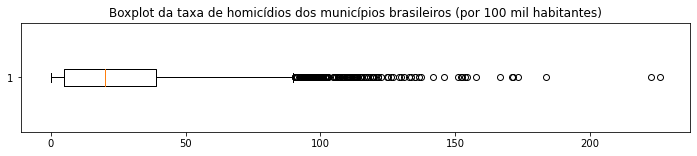

In [11]:
#Criando a array com os preços
data = df[['HOMICIDE_RATE']].values

#Criando o boxplot
fig1, ax1 = plt.subplots(figsize=(12,2))
ax1.set_title('Boxplot da taxa de homicídios dos municípios brasileiros (por 100 mil habitantes)')
ax1.boxplot(data, vert=False);

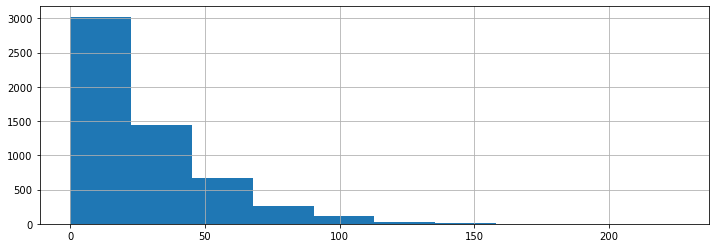

In [12]:
df['HOMICIDE_RATE'].hist(figsize=(12,4));

Agora, vamos contar os valores distintos em cada variável discreta.

In [13]:
df_nominal.nunique()

CITY             5298
STATE              27
REGIAO_TUR        323
CATEGORIA_TUR       6
RURAL_URBAN         6
GVA_MAIN           10
CLASS               2
dtype: int64

## 2. Tratamento de dados

### 2.1 Limpeza da base

In [14]:
df.drop(columns=['CITY', 'STATE'], inplace=True)

In [15]:
df['STATE_ID']=df['IBGE_ID'].astype('str').str[:2]
#df.set_index('IBGE_ID', inplace=True)
df.head()

,IBGE_ID,CAPITAL,IBGE_RES_POP_ESTR_PERC,IBGE_DU_RATE,IBGE_DU_RURAL_PERC,IBGE_POP_UP_PERC,IBGE_0-14_PERC,IBGE_15-59_PERC,IBGE_60+_PERC,IBGE_PLANTED_AREA,...,IBGE_ESTIMATED_POP_2017,HOMICIDES,HIDDEN_HOMICIDES,GINI_INDEX_2000,GINI_INDEX_2010,ILLITERACY_RATE_10+_2010,UNEMPLOYMENT_RATE_10+_2010,HOMICIDE_RATE,CLASS,STATE_ID
0,5200050,0,0.000000,0.310791,0.276556,0.770797,0.253208,0.668302,0.078491,319,...,8207,4,0,0.5005,0.4258,0.070333,0.325116,48.738881,endemic,52
1,3100104,0,0.000000,0.347255,0.363832,0.619630,0.206066,0.652143,0.141791,4479,...,7059,2,1,0.5110,0.4738,0.083573,0.345821,42.498938,endemic,31
2,5200100,0,0.009393,0.295424,0.305478,0.676271,0.259947,0.647147,0.092905,10307,...,18775,8,0,0.5493,0.4427,0.098286,0.382761,42.609854,endemic,52
3,3100203,0,0.000000,0.339092,0.133481,0.813751,0.206023,0.648776,0.145201,1862,...,23611,3,0,0.5862,0.5510,0.080375,0.327904,12.705942,endemic,31
4,1500107,0,0.000425,0.220135,0.386465,0.587923,0.282608,0.645113,0.072279,25200,...,153380,95,1,0.5865,0.5389,0.127095,0.490647,62.589647,endemic,15


In [16]:
encoder = ce.BinaryEncoder()
bin_cols = ['REGIAO_TUR','CATEGORIA_TUR', 'GVA_MAIN', 'RURAL_URBAN']
df_binary = encoder.fit_transform(df.loc[:,bin_cols])
df_binary.head()

,REGIAO_TUR_0,REGIAO_TUR_1,REGIAO_TUR_2,REGIAO_TUR_3,REGIAO_TUR_4,REGIAO_TUR_5,REGIAO_TUR_6,REGIAO_TUR_7,REGIAO_TUR_8,REGIAO_TUR_9,...,CATEGORIA_TUR_3,GVA_MAIN_0,GVA_MAIN_1,GVA_MAIN_2,GVA_MAIN_3,GVA_MAIN_4,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1


In [17]:
df = df.combine_first(df.merge(df_binary, left_index=True, right_index=True))
df

,ALT,AREA,BEDS,CAPITAL,CARS_RATE,CATEGORIA_TUR,CATEGORIA_TUR_0,CATEGORIA_TUR_1,CATEGORIA_TUR_2,CATEGORIA_TUR_3,...,RURAL_URBAN,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3,STATE_ID,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART
0,893.60,147.26,0,0,0.251427,Z,0.0,0.0,0.0,1.0,...,Urbano,0.0,0.0,0.0,1.0,52,20554.20,0,0.325116,0
1,753.12,881.06,0,0,0.319421,D,0.0,0.0,1.0,0.0,...,Rural Adjacente,0.0,0.0,1.0,0.0,31,12873.50,0,0.345821,0
2,1017.55,1045.13,408,0,0.144693,C,0.0,0.0,1.0,1.0,...,Rural Adjacente,0.0,0.0,1.0,0.0,52,26822.58,0,0.382761,0
3,644.74,1817.07,0,0,0.298325,D,0.0,0.0,1.0,0.0,...,Urbano,0.0,0.0,0.0,1.0,31,26994.09,0,0.327904,0
4,10.12,1610.65,144,0,0.033764,D,0.0,0.0,1.0,0.0,...,Urbano,0.0,0.0,0.0,1.0,15,95180.48,0,0.490647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,406.26,5079.66,392,0,0.045758,D,0.0,0.0,1.0,0.0,...,Urbano,0.0,0.0,0.0,1.0,29,13330.49,0,0.470280,0
5566,646.34,109.39,0,0,0.039101,E,0.0,1.0,0.0,0.0,...,Rural Adjacente,0.0,0.0,1.0,0.0,25,635.10,0,0.313161,0
5567,415.85,319.06,20,0,0.335693,Z,0.0,0.0,0.0,1.0,...,Rural Adjacente,0.0,0.0,1.0,0.0,35,1988.33,0,0.294608,0
5568,35.66,2140.11,0,0,0.033514,Z,0.0,0.0,0.0,1.0,...,Urbano,0.0,0.0,0.0,1.0,21,22610.35,0,0.474794,0


### 2.2 Missing values

Os atributos com valores faltantes foram identificados e organizados em grupos:

In [18]:
# Carregando a base
missing_groups = pd.read_csv('MISSING_FIELDS.csv', 
                             encoding='ansi')
missing_groups

,Campo,Tipo,Tratamento
0,IBGE_RES_POP_ESTR_PERC,Taxa ou índice,Substituição pela mediana
1,IBGE_DU_RATE,Taxa ou índice,Substituição pela mediana
2,IBGE_DU_RURAL_PERC,Taxa ou índice,Substituição pela mediana
3,IBGE_POP_UP_PERC,Taxa ou índice,Substituição pela mediana
4,IDHM Ranking 2010,Taxa ou índice,Substituição pela mediana
5,IDHM,Taxa ou índice,Substituição pela mediana
6,IDHM_Renda,Taxa ou índice,Substituição pela mediana
7,IDHM_Longevidade,Taxa ou índice,Substituição pela mediana
8,IDHM_Educacao,Taxa ou índice,Substituição pela mediana
9,CARS_RATE,Taxa ou índice,Substituição pela mediana


In [19]:
#Dividindo os grupos em arrays
missing_tax = list(missing_groups[missing_groups['Tipo']=='Taxa ou índice']['Campo'].to_numpy())
missing_per = list(missing_groups[missing_groups['Tipo']=='Percentual composto']['Campo'].to_numpy())
missing_geo = list(missing_groups[missing_groups['Tipo']=='Geográfica']['Campo'].to_numpy())
missing_abs = list(missing_groups[missing_groups['Tipo']=='Valor absoluto']['Campo'].to_numpy())

In [20]:
for i in range(len(missing_tax)):
    df[[missing_tax[i]]] = df[[missing_tax[i]]].fillna(np.nanmedian(df[[missing_tax[i]]]))
    
for i in range(len(missing_per)):
    df[[missing_per[i]]] = df[[missing_per[i]]].fillna(np.nanmean(df[[missing_per[i]]]))

In [21]:
geo_means = df.groupby(['STATE_ID', 'REGIAO_TUR'])[missing_geo].mean().reset_index()

dict_geo = {}
for i in range(len(missing_geo)):
    dict_geo[missing_geo[i]] =  missing_geo[i]+'_mean'
        
geo_means = geo_means.rename(columns=dict_geo)  

df_geo = df.combine_first(df.merge(geo_means, on=['STATE_ID', 'REGIAO_TUR'], how='left'))

In [22]:
for i in range(len(missing_geo)):
    df_geo[missing_geo[i]] = df_geo[missing_geo[i]].fillna(df_geo[dict_geo[missing_geo[i]]])
    df_geo = df_geo.drop(columns=dict_geo[missing_geo[i]])

In [23]:
#Agora que a coluna REGIAO_TUR já foi usada, 
#podemos removê-la, junto com as outras 
#que foram usadas no encoding:

df = df_geo.drop(columns=bin_cols)
df['STATE_ID'] = df['STATE_ID'].astype(str).astype(int)

In [24]:
isna = df.isna().sum().sum()
abs_isna = df[missing_abs].isna().sum().sum()
if abs_isna == isna:
    print('Só restam missing values no(s) campo(s)')
    for i in range(len(missing_abs)):  
        print(missing_abs[i])

Só restam missing values no(s) campo(s)
MUN_EXPENDIT


In [25]:
y_mean = df['MUN_EXPENDIT'].mean()

Agora, só falta tratar uma coluna de *missing values*, por regressão linear.  
Para isso, a base será normalizada e será usada apenas uma parte do *dataset*, onde não há valores faltantes do campo **MUN_EXPENDIT** e só existem valores numéricos.

In [26]:
#Criando a matriz normalizada excluindo valores não-numéricos
x = df.drop(columns=['CLASS', 'IBGE_ID']).values

#Normalização
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

#Nomeando as colunas
df_norm.columns = df.drop(columns=['CLASS', 'IBGE_ID']).columns

#Adicionando o coeficiente constante
df_norm['COEF']=1

df_norm

,ALT,AREA,BEDS,CAPITAL,CARS_RATE,CATEGORIA_TUR_0,CATEGORIA_TUR_1,CATEGORIA_TUR_2,CATEGORIA_TUR_3,COMP_A,...,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3,STATE_ID,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART,COEF
0,0.001022,0.000901,0.000000,0.0,0.383364,0.0,0.0,0.0,1.0,0.002567,...,0.0,0.0,0.0,1.0,0.976190,0.000296,0.0,0.353319,0.0,1
1,0.000861,0.005500,0.000000,0.0,0.487058,0.0,0.0,1.0,0.0,0.003080,...,0.0,0.0,1.0,0.0,0.476190,0.000231,0.0,0.385452,0.0,1
2,0.001163,0.006529,0.006155,0.0,0.220587,0.0,0.0,1.0,1.0,0.002567,...,0.0,0.0,1.0,0.0,0.976190,0.000350,0.0,0.442781,0.0,1
3,0.000737,0.011368,0.000000,0.0,0.454886,0.0,0.0,1.0,0.0,0.009240,...,0.0,0.0,0.0,1.0,0.476190,0.000351,0.0,0.357646,0.0,1
4,0.000012,0.010074,0.002172,0.0,0.051413,0.0,0.0,1.0,0.0,0.002053,...,0.0,0.0,0.0,1.0,0.095238,0.000933,0.0,0.610216,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0.000465,0.031819,0.005913,0.0,0.069705,0.0,0.0,1.0,0.0,0.001027,...,0.0,0.0,0.0,1.0,0.428571,0.000235,0.0,0.578608,0.0,1
5566,0.000739,0.000663,0.000000,0.0,0.059553,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.333333,0.000126,0.0,0.334764,0.0,1
5567,0.000475,0.001978,0.000302,0.0,0.511875,0.0,0.0,0.0,1.0,0.033368,...,0.0,0.0,1.0,0.0,0.571429,0.000138,0.0,0.305970,0.0,1
5568,0.000041,0.013393,0.000000,0.0,0.051033,0.0,0.0,0.0,1.0,0.001540,...,0.0,0.0,0.0,1.0,0.238095,0.000314,0.0,0.585613,0.0,1


In [27]:
#Criando o dataframe para regressão
df_abs = df_norm[df_norm.MUN_EXPENDIT.notnull()].reset_index().drop(columns=['index'])

#Guardando y em um dataframe separado
df_y = df[df.MUN_EXPENDIT.notnull()][['MUN_EXPENDIT']].reset_index().drop(columns=['index'])

#Removendo y
df_abs = df_abs.drop(columns=['MUN_EXPENDIT'])
print(df_abs.shape, df_y.shape)

(4080, 105) (4080, 1)


In [28]:
X = df_abs
y = df_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_, regr.coef_.shape)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# Comparando MSE e y médio
mse_y = np.sqrt(mean_squared_error(y_test, y_pred))/y_mean
print('sqrt(MSE)/y médio: %.2f'
      % mse_y)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[-1.71466940e+06  4.92022920e+07  4.57252198e+08  2.19512590e+08
   4.84172082e+06  4.66256395e+06  1.91140214e+07  9.48273453e+06
   7.92562445e+06 -6.23541793e+06  3.80153442e+08 -8.99578896e+08
   7.87449974e+07  1.39940467e+09 -1.34105275e+09 -6.23524190e+09
   2.59538059e+09  9.23701103e+08  1.01484153e+10  1.06414205e+10
  -3.50508046e+09 -1.21737808e+10  7.55243823e+09  5.16791468e+08
  -3.54392438e+09  3.87986069e+09  2.24953064e+09 -6.28986440e+08
   9.07619114e+06  6.53364562e+09 -3.38592757e+09 -5.78053116e+09
   3.84617132e+09  3.95146475e+07  4.92655578e+06 -5.81801117e+06
  -8.69031209e+06  1.19358714e+09  1.17110292e+07  2.74826697e+07
  -6.57181556e+05 -1.41980728e+06 -9.46830807e+05  1.70938455e+09
   2.39677857e+09  3.45313717e+09 -3.59614090e+08 -1.22262369e+09
   3.66501551e+07 -1.04733225e+08  6.32886400e+14  5.16959505e+14
   7.56031256e+14  4.40757019e+07  1.36123769e+06  3.59047733e+05
   9.23112377e+08  4.50957035e+08  5.94427965e+08  3.4983473

In [29]:
#Fazendo a análise detalhada
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           MUN_EXPENDIT   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.231e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:20:56   Log-Likelihood:                -76874.
No. Observations:                4080   AIC:                         1.539e+05
Df Residuals:                    3981   BIC:                         1.546e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ALT                 

Apesar do alto $R^2$, o erro quadrático médio (MSE) é bem alto $(\sqrt{\mathrm{MSE}}\approx2.3\bar{y})$, além de terem diversas variáveis com p-valor alto.  
Do mesmo modo, há muitas outras com p-valor bem baixo, então podemos aplicar uma nova iteração da regressão linear e avaliar os resultados.  
Serão mantidas as variáveis com $p<0.05$.

In [30]:
#Criando a matriz normalizada selecionando variáveis com p-valor < 0.05 na iteração anterior
x = df[['AREA',
        'BEDS',
        'CAPITAL',
        'CATEGORIA_TUR_1',
        'COMP_B',
        'COMP_D',
        'COMP_G',
        'COMP_H',
        'COMP_I',
        'COMP_J',
        'COMP_K',
        'COMP_L',
        'COMP_M',
        'COMP_N',
        'COMP_O',
        'COMP_P',
        'COMP_Q',
        'COMP_R',
        'COMP_U',
        'GDP',
        'GDP_CAPITA',
        'GVA_INDUSTRY',
        'GVA_MAIN_1',
        'GVA_PUBLIC',
        'GVA_SERVICES',
        'GVA_TOTAL',
        'HOMICIDES',
        'IBGE_POP_10+_2010',
        'IDHM_Educacao',
        'IDHM_Renda',
        'MCDONALDS',
        'MUN_EXPENDIT',
        'PAY_TV',
        'Pr_Agencies',
        'Pr_Assets',
        'Pr_Bank',
        'Pu_Agencies',
        'Pu_Assets',
        'Pu_Bank',
        'REGIAO_TUR_5',
        'TAXES',
        'UBER',
        'UNEMPLOYMENT_RATE_10+_2010',
        'WALMART'
        ]].values

#Normalização
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

#Nomeando as colunas
df_norm.columns = ['AREA',
                    'BEDS',
                    'CAPITAL',
                    'CATEGORIA_TUR_1',
                    'COMP_B',
                    'COMP_D',
                    'COMP_G',
                    'COMP_H',
                    'COMP_I',
                    'COMP_J',
                    'COMP_K',
                    'COMP_L',
                    'COMP_M',
                    'COMP_N',
                    'COMP_O',
                    'COMP_P',
                    'COMP_Q',
                    'COMP_R',
                    'COMP_U',
                    'GDP',
                    'GDP_CAPITA',
                    'GVA_INDUSTRY',
                    'GVA_MAIN_1',
                    'GVA_PUBLIC',
                    'GVA_SERVICES',
                    'GVA_TOTAL',
                    'HOMICIDES',
                    'IBGE_POP_10+_2010',
                    'IDHM_Educacao',
                    'IDHM_Renda',
                    'MCDONALDS',
                    'MUN_EXPENDIT',
                    'PAY_TV',
                    'Pr_Agencies',
                    'Pr_Assets',
                    'Pr_Bank',
                    'Pu_Agencies',
                    'Pu_Assets',
                    'Pu_Bank',
                    'REGIAO_TUR_5',
                    'TAXES',
                    'UBER',
                    'UNEMPLOYMENT_RATE_10+_2010',
                    'WALMART'
                    ]

#Adicionando o coeficiente constante
df_norm['COEF']=1

df_norm

,AREA,BEDS,CAPITAL,CATEGORIA_TUR_1,COMP_B,COMP_D,COMP_G,COMP_H,COMP_I,COMP_J,...,Pr_Bank,Pu_Agencies,Pu_Assets,Pu_Bank,REGIAO_TUR_5,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART,COEF
0,0.000901,0.000000,0.0,0.0,0.003650,0.000000,0.000724,0.001332,0.000137,0.000129,...,0.000000,0.000000,0.000000,0.000,0.0,0.000296,0.0,0.353319,0.0,1
1,0.005500,0.000000,0.0,0.0,0.021898,0.003012,0.001255,0.003587,0.000956,0.000284,...,0.000000,0.000000,0.000000,0.000,0.0,0.000231,0.0,0.385452,0.0,1
2,0.006529,0.006155,0.0,0.0,0.032847,0.000000,0.000770,0.000615,0.001946,0.000052,...,0.012048,0.001597,0.000008,0.125,0.0,0.000350,0.0,0.442781,0.0,1
3,0.011368,0.000000,0.0,0.0,0.003650,0.000000,0.002005,0.003177,0.001024,0.000232,...,0.024096,0.003195,0.000046,0.250,0.0,0.000351,0.0,0.357646,0.0,1
4,0.010074,0.002172,0.0,0.0,0.007299,0.000000,0.003313,0.000820,0.001058,0.000155,...,0.024096,0.006390,0.000100,0.500,0.0,0.000933,0.0,0.610216,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0.031819,0.005913,0.0,0.0,0.003650,0.000000,0.001978,0.000307,0.000376,0.000052,...,0.012048,0.004792,0.000034,0.375,0.0,0.000235,0.0,0.578608,0.0,1
5566,0.000663,0.000000,0.0,1.0,0.000000,0.000000,0.000046,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,1.0,0.000126,0.0,0.334764,0.0,1
5567,0.001978,0.000302,0.0,0.0,0.000000,0.000000,0.000106,0.000205,0.000171,0.000000,...,0.000000,0.000000,0.000000,0.000,0.0,0.000138,0.0,0.305970,0.0,1
5568,0.013393,0.000000,0.0,0.0,0.000000,0.000000,0.002211,0.000256,0.000444,0.000103,...,0.012048,0.004792,0.000066,0.375,0.0,0.000314,0.0,0.585613,0.0,1


In [31]:
#Criando o dataframe para regressão
df_abs = df_norm[df_norm.MUN_EXPENDIT.notnull()].reset_index().drop(columns=['index'])

#Guardando y em um dataframe separado
df_y = df[df.MUN_EXPENDIT.notnull()][['MUN_EXPENDIT']].reset_index().drop(columns=['index'])

#Removendo y
df_abs = df_abs.drop(columns=['MUN_EXPENDIT'])
print(df_abs.shape, df_y.shape)

(4080, 44) (4080, 1)


In [32]:
X = df_abs
y = df_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_, regr.coef_.shape)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# Comparando MSE e y médio
mse_y = np.sqrt(mean_squared_error(y_test, y_pred))/y_mean
print('sqrt(MSE)/y médio: %.2f'
      % mse_y)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[ 6.82854025e+07  1.90813588e+08  2.65100541e+08  9.64681206e+06
   4.14247510e+08  2.00793526e+08  2.17268268e+09  1.81910902e+09
   3.42338182e+08  1.07860457e+10  4.43196167e+09 -8.82783664e+09
  -1.07397406e+10  8.42823945e+09  7.81548241e+08  8.12258884e+08
   4.04151780e+09  3.55483964e+09 -5.33456910e+09  5.59477770e+09
   7.95372104e+06  1.17899946e+09  2.84233635e+07  2.01380579e+09
   2.64160567e+09  4.09514653e+09  6.75117220e+08 -3.40843522e+07
   2.42635318e+07 -3.21840886e+07  1.88202303e+09  6.68928073e+09
   1.72198891e+10 -3.69719401e+09 -7.79285419e+08 -5.56524531e+09
   6.58395943e+08  1.30668117e+08 -3.97510377e+06  1.79870837e+09
   2.41484986e+07  3.10424169e+07 -5.54137066e+08  8.98446753e+06]] (1, 44)
Mean squared error: 13361142354643984.00
sqrt(MSE)/y médio: 1.11
Coefficient of determination: 0.99


In [33]:
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           MUN_EXPENDIT   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.577e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:20:56   Log-Likelihood:                -77116.
No. Observations:                4080   AIC:                         1.543e+05
Df Residuals:                    4036   BIC:                         1.546e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
AREA                

O MSE teve uma redução substancial, mas ainda está alto $(\sqrt{\mathrm{MSE}}\approx1.1\bar{y})$

In [34]:
#Criando a matriz normalizada selecionando variáveis com p-valor < 0.05 na iteração anterior
x = df[['CAPITAL',
        'COMP_J',
        'COMP_L',
        'COMP_M',
        'COMP_N',
        'COMP_O',
        'COMP_R',
        'GDP',
        'GVA_INDUSTRY',
        'GVA_SERVICES',
        'HOMICIDES',
        'MUN_EXPENDIT',
        'PAY_TV',
        'Pr_Agencies',
        'Pr_Assets',
        'Pu_Agencies',
        'Pu_Bank'
        ]].values

#Normalização
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

#Nomeando as colunas
df_norm.columns = ['CAPITAL',
                    'COMP_J',
                    'COMP_L',
                    'COMP_M',
                    'COMP_N',
                    'COMP_O',
                    'COMP_R',
                    'GDP',
                    'GVA_INDUSTRY',
                    'GVA_SERVICES',
                    'HOMICIDES',
                    'MUN_EXPENDIT',
                    'PAY_TV',
                    'Pr_Agencies',
                    'Pr_Assets',
                    'Pu_Agencies',
                    'Pu_Bank'
                    ]

#Adicionando o coeficiente constante
df_norm['COEF']=1

df_norm

,CAPITAL,COMP_J,COMP_L,COMP_M,COMP_N,COMP_O,COMP_R,GDP,GVA_INDUSTRY,GVA_SERVICES,HOMICIDES,MUN_EXPENDIT,PAY_TV,Pr_Agencies,Pr_Assets,Pu_Agencies,Pu_Bank,COEF
0,0.0,0.000129,0.000143,0.000203,0.000156,0.019608,0.000150,2.204397e-07,0.000442,1.608674e-04,0.001865,0.000586,1.753215e-04,0.000000,0.000000,0.000000,0.000,1
1,0.0,0.000284,0.000286,0.000305,0.000378,0.009804,0.000897,2.403514e-07,0.000409,1.349104e-04,0.000932,0.000360,3.711541e-05,0.000000,0.000000,0.000000,0.000,1
2,0.0,0.000052,0.000000,0.000142,0.000195,0.014706,0.000150,4.191477e-04,0.000264,2.974160e-04,0.003730,0.000789,1.103695e-04,0.000591,0.000002,0.001597,0.125,1
3,0.0,0.000232,0.000286,0.000569,0.000352,0.009804,0.001346,6.261979e-04,0.000490,3.662056e-07,0.001399,NaN,6.001952e-04,0.001181,0.000002,0.003195,0.250,1
4,0.0,0.000155,0.000071,0.000447,0.000208,0.009804,0.002243,1.818304e-03,0.000926,1.007467e-03,0.044289,NaN,1.654566e-03,0.001181,0.000004,0.006390,0.500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0.0,0.000052,0.000000,0.000102,0.000117,0.009804,0.000449,4.981488e-04,0.000213,2.525452e-04,0.007925,NaN,8.204459e-05,0.000591,0.000003,0.004792,0.375,1
5566,0.0,0.000000,0.000000,0.000020,0.000000,0.009804,0.000000,2.848046e-05,0.000011,4.196644e-09,0.000466,NaN,4.883607e-07,0.000000,0.000000,0.000000,0.000,1
5567,0.0,0.000000,0.000000,0.000020,0.000013,0.014706,0.000299,1.105036e-04,0.000105,3.051714e-08,0.000000,0.000359,7.520754e-05,0.000000,0.000000,0.000000,0.000,1
5568,0.0,0.000103,0.000143,0.000122,0.000117,0.009804,0.000449,5.538202e-04,0.000257,3.300499e-07,0.010256,0.001661,3.170437e-03,0.000591,0.000002,0.004792,0.375,1


In [35]:
#Criando o dataframe para regressão
df_abs = df_norm[df_norm.MUN_EXPENDIT.notnull()].reset_index().drop(columns=['index'])

#Guardando y em um dataframe separado
df_y = df[df.MUN_EXPENDIT.notnull()][['MUN_EXPENDIT']].reset_index().drop(columns=['index'])

#Removendo y
df_abs = df_abs.drop(columns=['MUN_EXPENDIT'])
print(df_abs.shape, df_y.shape)

(4080, 17) (4080, 1)


In [36]:
X = df_abs
y = df_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_, regr.coef_.shape)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# Comparando MSE e y médio
mse_y = np.sqrt(mean_squared_error(y_test, y_pred))/y_mean
print('sqrt(MSE)/y médio: %.2f'
      % mse_y)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[ 3.62644789e+08  1.10907053e+10  1.30526103e+09 -1.10706517e+10
   7.17474570e+09  7.46695072e+08  2.66682534e+09  7.15827209e+09
   1.75395064e+09  1.08658539e+10  1.00276582e+09  1.09796161e+10
   1.03410879e+10 -4.14085711e+09 -3.83374203e+09  1.42872675e+08
   2.82281758e+06]] (1, 17)
Mean squared error: 1782567702692756.00
sqrt(MSE)/y médio: 0.40
Coefficient of determination: 1.00


In [37]:
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           MUN_EXPENDIT   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 9.067e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:20:58   Log-Likelihood:                -77750.
No. Observations:                4080   AIC:                         1.555e+05
Df Residuals:                    4063   BIC:                         1.556e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CAPITAL       3.154e+08   2.27e+07     13.870   

In [38]:
#Criando a matriz normalizada selecionando variáveis com p-valor < 0.05 na iteração anterior
x = df[[
'COMP_J',
'COMP_L',
'COMP_M',
'COMP_N',
'COMP_O',
'COMP_R',
'GDP',
'GVA_INDUSTRY',
'GVA_SERVICES',
'HOMICIDES',
'MUN_EXPENDIT',    
'PAY_TV',
'Pr_Agencies',
'Pu_Agencies',
'Pu_Bank'
        ]].values

#Normalização
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

#Nomeando as colunas
df_norm.columns = [
'COMP_J',
'COMP_L',
'COMP_M',
'COMP_N',
'COMP_O',
'COMP_R',
'GDP',
'GVA_INDUSTRY',
'GVA_SERVICES',
'HOMICIDES',
'MUN_EXPENDIT',    
'PAY_TV',
'Pr_Agencies',
'Pu_Agencies',
'Pu_Bank'
                  ]

#Adicionando o coeficiente constante
df_norm['COEF']=1

df_norm

,COMP_J,COMP_L,COMP_M,COMP_N,COMP_O,COMP_R,GDP,GVA_INDUSTRY,GVA_SERVICES,HOMICIDES,MUN_EXPENDIT,PAY_TV,Pr_Agencies,Pu_Agencies,Pu_Bank,COEF
0,0.000129,0.000143,0.000203,0.000156,0.019608,0.000150,2.204397e-07,0.000442,1.608674e-04,0.001865,0.000586,1.753215e-04,0.000000,0.000000,0.000,1
1,0.000284,0.000286,0.000305,0.000378,0.009804,0.000897,2.403514e-07,0.000409,1.349104e-04,0.000932,0.000360,3.711541e-05,0.000000,0.000000,0.000,1
2,0.000052,0.000000,0.000142,0.000195,0.014706,0.000150,4.191477e-04,0.000264,2.974160e-04,0.003730,0.000789,1.103695e-04,0.000591,0.001597,0.125,1
3,0.000232,0.000286,0.000569,0.000352,0.009804,0.001346,6.261979e-04,0.000490,3.662056e-07,0.001399,NaN,6.001952e-04,0.001181,0.003195,0.250,1
4,0.000155,0.000071,0.000447,0.000208,0.009804,0.002243,1.818304e-03,0.000926,1.007467e-03,0.044289,NaN,1.654566e-03,0.001181,0.006390,0.500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0.000052,0.000000,0.000102,0.000117,0.009804,0.000449,4.981488e-04,0.000213,2.525452e-04,0.007925,NaN,8.204459e-05,0.000591,0.004792,0.375,1
5566,0.000000,0.000000,0.000020,0.000000,0.009804,0.000000,2.848046e-05,0.000011,4.196644e-09,0.000466,NaN,4.883607e-07,0.000000,0.000000,0.000,1
5567,0.000000,0.000000,0.000020,0.000013,0.014706,0.000299,1.105036e-04,0.000105,3.051714e-08,0.000000,0.000359,7.520754e-05,0.000000,0.000000,0.000,1
5568,0.000103,0.000143,0.000122,0.000117,0.009804,0.000449,5.538202e-04,0.000257,3.300499e-07,0.010256,0.001661,3.170437e-03,0.000591,0.004792,0.375,1


In [39]:
#Criando o dataframe para regressão
df_abs = df_norm[df_norm.MUN_EXPENDIT.notnull()].reset_index().drop(columns=['index'])

#Guardando y em um dataframe separado
df_y = df[df.MUN_EXPENDIT.notnull()][['MUN_EXPENDIT']].reset_index().drop(columns=['index'])

#Removendo y
df_abs = df_abs.drop(columns=['MUN_EXPENDIT'])
print(df_abs.shape, df_y.shape)

(4080, 15) (4080, 1)


In [40]:
X = df_abs
y = df_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_, regr.coef_.shape)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# Comparando MSE e y médio
mse_y = np.sqrt(mean_squared_error(y_test, y_pred))/y_mean
print('sqrt(MSE)/y médio: %.4f'
      % mse_y)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[ 7.83496859e+09  1.74572365e+09 -9.34074305e+09  6.94237044e+09
   1.52478428e+09  4.64160755e+09  5.91957994e+09  2.21090571e+09
   4.81756393e+09  1.06030787e+09  1.02238280e+10  1.12269885e+10
  -2.53497209e+09  1.18305851e+08 -6.95659678e+06]] (1, 15)
Mean squared error: 1734870301668176.75
sqrt(MSE)/y médio: 0.3993
Coefficient of determination: 1.00


In [41]:
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           MUN_EXPENDIT   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 8.932e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:20:59   Log-Likelihood:                -78053.
No. Observations:                4080   AIC:                         1.561e+05
Df Residuals:                    4065   BIC:                         1.562e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
COMP_J        8.653e+09   4.55e+08     19.039   

Após testar diversas combinações de colunas, foi escolhido o conjunto de 16 colunas, com $\sqrt{\mathrm{MSE}}\approx0.4\bar{y}$. 

In [42]:
df_mun = df[['IBGE_ID', 'MUN_EXPENDIT', 'CLASS']]

In [43]:
df_reg = regr.coef_ * df_norm.drop(columns='MUN_EXPENDIT')
df_reg

,COMP_J,COMP_L,COMP_M,COMP_N,COMP_O,COMP_R,GDP,GVA_INDUSTRY,GVA_SERVICES,HOMICIDES,PAY_TV,Pr_Agencies,Pu_Agencies,Pu_Bank,COEF
0,1.011747e+06,249335.664078,-1.899258e+06,1.085353e+06,2.989773e+07,6.941241e+05,1.304911e+03,9.775393e+05,7.749889e+05,1.977264e+06,1.792457e+06,0.000000e+00,-0.000000e+00,0.000000e+00,-6.956597e+06
1,2.225843e+06,498671.328156,-2.848888e+06,2.622937e+06,1.494887e+07,4.164744e+06,1.422779e+03,9.051233e+05,6.499395e+05,9.886320e+05,3.794616e+05,0.000000e+00,-0.000000e+00,0.000000e+00,-6.956597e+06
2,4.046988e+05,0.000000,-1.329481e+06,1.356691e+06,2.242330e+07,6.941241e+05,2.481179e+06,5.841955e+05,1.432820e+06,3.954528e+06,1.128399e+06,6.631417e+06,-4.049476e+06,1.478823e+07,-6.956597e+06
3,1.821145e+06,498671.328156,-5.317924e+06,2.442044e+06,1.494887e+07,6.247116e+06,3.706828e+06,1.082708e+06,1.764219e+03,1.482948e+06,6.136293e+06,1.326283e+07,-8.098952e+06,2.957646e+07,-6.956597e+06
4,1.214096e+06,124667.832039,-4.178369e+06,1.447137e+06,1.494887e+07,1.041186e+07,1.076360e+07,2.046859e+06,4.853536e+06,4.696002e+07,1.691600e+07,1.326283e+07,-1.619790e+07,5.915293e+07,-6.956597e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,4.046988e+05,0.000000,-9.496292e+05,8.140148e+05,1.494887e+07,2.082372e+06,2.948832e+06,4.699870e+05,1.216653e+06,8.403372e+06,8.388098e+05,6.631417e+06,-1.214843e+07,4.436469e+07,-6.956597e+06
5566,0.000000e+00,0.000000,-1.899258e+05,0.000000e+00,1.494887e+07,0.000000e+00,1.685924e+05,2.458244e+04,2.021760e+01,4.943160e+05,4.992915e+03,0.000000e+00,-0.000000e+00,0.000000e+00,-6.956597e+06
5567,0.000000e+00,0.000000,-1.899258e+05,9.044609e+04,2.242330e+07,1.388248e+06,6.541348e+05,2.324814e+05,1.470182e+02,0.000000e+00,7.689090e+05,0.000000e+00,-0.000000e+00,0.000000e+00,-6.956597e+06
5568,8.093976e+05,249335.664078,-1.139555e+06,8.140148e+05,1.494887e+07,2.082372e+06,3.278383e+06,5.689740e+05,1.590037e+03,1.087495e+07,3.241401e+07,6.631417e+06,-1.214843e+07,4.436469e+07,-6.956597e+06


In [44]:
mun_reg = df_reg.sum(axis=1)
mun_reg = mun_reg.to_frame()
df_mun = df_mun.combine_first(df_mun.merge(mun_reg, left_index=True, right_index=True))
df_mun.rename(columns={0:'MUN_EXPENDIT_reg'}, inplace=True)
df_mun

,MUN_EXPENDIT_reg,CLASS,IBGE_ID,MUN_EXPENDIT
0,2.960599e+07,endemic,5200050,28227691.0
1,1.758016e+07,endemic,3100104,17909274.0
2,4.354403e+07,endemic,5200100,37513019.0
3,6.083421e+07,endemic,3100203,NaN
4,1.547695e+08,endemic,1500107,NaN
...,...,...,...,...
5565,6.306906e+07,endemic,2933604,NaN
5566,8.494847e+06,endemic,2517407,NaN
5567,1.841114e+07,less violent,3557154,17866486.0
5568,9.679342e+07,endemic,2114007,77454982.0


In [45]:
df.shape

(5570, 107)

In [46]:
df_nomiss = df.combine_first(df.merge(df_mun['MUN_EXPENDIT_reg'], left_index=True, right_index=True))
df_nomiss['MUN_EXPENDIT'] = df_nomiss['MUN_EXPENDIT'].fillna(df_nomiss['MUN_EXPENDIT_reg'])
df_nomiss = df_nomiss.drop(columns=['MUN_EXPENDIT_reg', 'HOMICIDES', 'HIDDEN_HOMICIDES', 'HOMICIDE_RATE'])
df_nomiss

,ALT,AREA,BEDS,CAPITAL,CARS_RATE,CATEGORIA_TUR_0,CATEGORIA_TUR_1,CATEGORIA_TUR_2,CATEGORIA_TUR_3,CLASS,...,REGIAO_TUR_9,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3,STATE_ID,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART
0,893.60,147.26,0,0,0.251427,0.0,0.0,0.0,1.0,endemic,...,1.0,0.0,0.0,0.0,1.0,52,20554.20,0,0.325116,0
1,753.12,881.06,0,0,0.319421,0.0,0.0,1.0,0.0,endemic,...,0.0,0.0,0.0,1.0,0.0,31,12873.50,0,0.345821,0
2,1017.55,1045.13,408,0,0.144693,0.0,0.0,1.0,1.0,endemic,...,1.0,0.0,0.0,1.0,0.0,52,26822.58,0,0.382761,0
3,644.74,1817.07,0,0,0.298325,0.0,0.0,1.0,0.0,endemic,...,0.0,0.0,0.0,0.0,1.0,31,26994.09,0,0.327904,0
4,10.12,1610.65,144,0,0.033764,0.0,0.0,1.0,0.0,endemic,...,1.0,0.0,0.0,0.0,1.0,15,95180.48,0,0.490647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,406.26,5079.66,392,0,0.045758,0.0,0.0,1.0,0.0,endemic,...,0.0,0.0,0.0,0.0,1.0,29,13330.49,0,0.470280,0
5566,646.34,109.39,0,0,0.039101,0.0,1.0,0.0,0.0,endemic,...,0.0,0.0,0.0,1.0,0.0,25,635.10,0,0.313161,0
5567,415.85,319.06,20,0,0.335693,0.0,0.0,0.0,1.0,less violent,...,1.0,0.0,0.0,1.0,0.0,35,1988.33,0,0.294608,0
5568,35.66,2140.11,0,0,0.033514,0.0,0.0,0.0,1.0,endemic,...,1.0,0.0,0.0,0.0,1.0,21,22610.35,0,0.474794,0


### 2.2 Outliers

Nº de outliers: 611


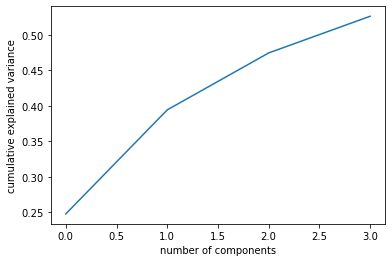

In [47]:
x = df_nomiss.drop(columns=['CLASS','IBGE_ID']).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)

n_pca = 4# X.shape[1]
pca = PCA(n_components=n_pca)
pca.fit(X)
X = pca.transform(X)

outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 5,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(X)

X = pd.DataFrame(X)
X[n_pca]=y
X['cluster']=clusters

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print('Nº de outliers:',-sum(X['cluster'][X['cluster']==-1]))

In [48]:
#Normalização
x = df_nomiss.drop(columns=['CLASS','IBGE_ID']).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

#Selecionando variáveis para a análise de outliers
#Método Variance Threshold (ou limite de variância)
vt = .72
sel = VarianceThreshold(threshold=(vt*(1-vt)))
sel.fit_transform(X)
X = X[X.columns[sel.get_support(indices=True)]]
print('Foram selecionados', X.shape[1], 'atributos.')

Foram selecionados 10 atributos.


In [49]:
outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 5,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(X)

X['cluster']=clusters
print('Nº de outliers:',-sum(X['cluster'][X['cluster']==-1]))

Nº de outliers: 561


Nº de outliers: 561


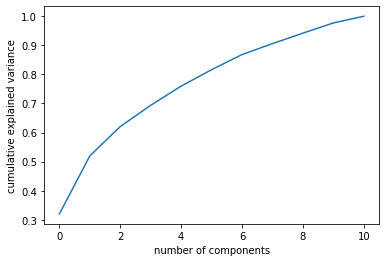

In [50]:
x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)

n_pca = X.shape[1]
pca = PCA(n_components=n_pca)
pca.fit(X)
X_pca = pca.transform(X)

outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 5,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(X_pca)

X_pca = pd.DataFrame(X_pca)
X_pca[n_pca]=y
X_pca['cluster']=clusters

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print('Nº de outliers:',-sum(X_pca['cluster'][X_pca['cluster']==-1]))

In [51]:
df_noout = df_nomiss
df_noout['cluster'] = X_pca['cluster']
df_noout = df_noout[df_noout['cluster']!=-1].drop(columns='cluster')
df_noout

,ALT,AREA,BEDS,CAPITAL,CARS_RATE,CATEGORIA_TUR_0,CATEGORIA_TUR_1,CATEGORIA_TUR_2,CATEGORIA_TUR_3,CLASS,...,REGIAO_TUR_9,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3,STATE_ID,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART
0,893.60,147.26,0,0,0.251427,0.0,0.0,0.0,1.0,endemic,...,1.0,0.0,0.0,0.0,1.0,52,20554.20,0,0.325116,0
1,753.12,881.06,0,0,0.319421,0.0,0.0,1.0,0.0,endemic,...,0.0,0.0,0.0,1.0,0.0,31,12873.50,0,0.345821,0
3,644.74,1817.07,0,0,0.298325,0.0,0.0,1.0,0.0,endemic,...,0.0,0.0,0.0,0.0,1.0,31,26994.09,0,0.327904,0
4,10.12,1610.65,144,0,0.033764,0.0,0.0,1.0,0.0,endemic,...,1.0,0.0,0.0,0.0,1.0,15,95180.48,0,0.490647,0
5,403.11,180.08,0,0,0.047415,0.0,0.0,0.0,1.0,endemic,...,1.0,0.0,0.0,1.0,0.0,23,4042.79,0,0.389942,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,184.32,110.82,0,0,0.057859,0.0,0.0,0.0,1.0,endemic,...,1.0,0.0,0.0,1.0,0.0,26,7.42,0,0.498686,0
5565,406.26,5079.66,392,0,0.045758,0.0,0.0,1.0,0.0,endemic,...,0.0,0.0,0.0,0.0,1.0,29,13330.49,0,0.470280,0
5566,646.34,109.39,0,0,0.039101,0.0,1.0,0.0,0.0,endemic,...,0.0,0.0,0.0,1.0,0.0,25,635.10,0,0.313161,0
5567,415.85,319.06,20,0,0.335693,0.0,0.0,0.0,1.0,less violent,...,1.0,0.0,0.0,1.0,0.0,35,1988.33,0,0.294608,0


### 2.3 Balanceamento

In [52]:
print('São',
      df_nomiss[df_nomiss.CLASS == 'endemic'].shape[0], 
      'municípios classificados como endêmicos e',
      df_nomiss[df_nomiss.CLASS == 'less violent'].shape[0],
      'classificados como menos violentos.')

São 3815 municípios classificados como endêmicos e 1755 classificados como menos violentos.


Counter({1: 3815, 0: 1755})


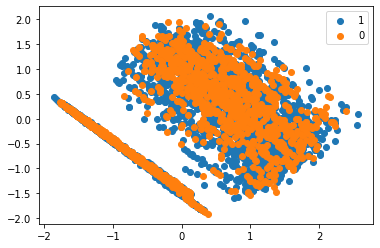

In [53]:
X = df_nomiss.drop(columns=['CLASS','IBGE_ID']).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X_norm = pd.DataFrame(x_scaled)

n_pca = 2
pca = PCA(n_components=n_pca)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

Y = df_nomiss[['CLASS']]
Y = np.transpose(Y.replace(['endemic','less violent'],[1,0]).values)[0]

counter = Counter(Y)
print(counter)
for label, _ in counter.items():
	row_ix = np.where(Y == label)[0]
	plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [54]:
#Fazendo o oversampling
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [55]:
df_bal = pd.DataFrame(X)
df_bal.columns = df_nomiss.drop(columns=['CLASS','IBGE_ID']).columns
df_bal['CLASS'] = Y
df_bal = df_bal.drop(columns=['cluster'])
df_bal

,ALT,AREA,BEDS,CAPITAL,CARS_RATE,CATEGORIA_TUR_0,CATEGORIA_TUR_1,CATEGORIA_TUR_2,CATEGORIA_TUR_3,COMP_A,...,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3,STATE_ID,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART,CLASS
0,893.600000,147.260000,0.000000,0.0,0.251427,0.0,0.000000,0.00000,1.000000,5.000000,...,0.0,0.000000,0.000000,1.0,52.000000,20554.200000,0.0,0.325116,0.0,1
1,753.120000,881.060000,0.000000,0.0,0.319421,0.0,0.000000,1.00000,0.000000,6.000000,...,0.0,0.000000,1.000000,0.0,31.000000,12873.500000,0.0,0.345821,0.0,1
2,1017.550000,1045.130000,408.000000,0.0,0.144693,0.0,0.000000,1.00000,1.000000,5.000000,...,0.0,0.000000,1.000000,0.0,52.000000,26822.580000,0.0,0.382761,0.0,1
3,644.740000,1817.070000,0.000000,0.0,0.298325,0.0,0.000000,1.00000,0.000000,18.000000,...,0.0,0.000000,0.000000,1.0,31.000000,26994.090000,0.0,0.327904,0.0,1
4,10.120000,1610.650000,144.000000,0.0,0.033764,0.0,0.000000,1.00000,0.000000,4.000000,...,0.0,0.000000,0.000000,1.0,15.000000,95180.480000,0.0,0.490647,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7625,435.593397,3011.838576,51.161547,0.0,0.186173,0.0,0.000000,0.30095,0.699050,2.097149,...,0.0,1.000000,0.000000,0.0,28.291447,37461.830386,0.0,0.356505,0.0,0
7626,941.667625,137.041091,44.254709,0.0,0.087836,0.0,1.000000,0.00000,0.000000,0.148948,...,0.0,0.851052,0.148948,0.0,31.000000,8986.294311,0.0,0.385288,0.0,0
7627,439.966097,316.393535,14.640272,0.0,0.317089,0.0,0.267986,0.00000,0.732014,47.848869,...,0.0,0.000000,1.000000,0.0,36.607918,2600.780791,0.0,0.309433,0.0,0
7628,748.561061,783.741091,0.000000,0.0,0.117723,0.0,0.000000,1.00000,0.000000,1.693798,...,0.0,0.000000,1.000000,0.0,30.387596,1955.659938,0.0,0.387911,0.0,0


Counter({1: 3815, 0: 3815})


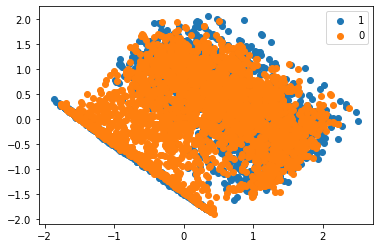

In [56]:
X = df_bal.drop(columns=['CLASS']).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X_norm = pd.DataFrame(x_scaled)

n_pca = 2
pca = PCA(n_components=n_pca)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

Y = df_bal[['CLASS']]
Y = np.transpose(Y.values)[0]

counter = Counter(Y)
print(counter)
for label, _ in counter.items():
	row_ix = np.where(Y == label)[0]
	plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### 2.4 Normalização

In [57]:
x = df_nomiss.drop(columns=['CLASS','IBGE_ID','cluster']).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)
df_norm.columns = df_nomiss.drop(columns=['CLASS','IBGE_ID','cluster']).columns
df_norm

,ALT,AREA,BEDS,CAPITAL,CARS_RATE,CATEGORIA_TUR_0,CATEGORIA_TUR_1,CATEGORIA_TUR_2,CATEGORIA_TUR_3,COMP_A,...,REGIAO_TUR_9,RURAL_URBAN_0,RURAL_URBAN_1,RURAL_URBAN_2,RURAL_URBAN_3,STATE_ID,TAXES,UBER,UNEMPLOYMENT_RATE_10+_2010,WALMART
0,0.001022,0.000901,0.000000,0.0,0.383364,0.0,0.0,0.0,1.0,0.002567,...,1.0,0.0,0.0,0.0,1.0,0.976190,0.000296,0.0,0.353319,0.0
1,0.000861,0.005500,0.000000,0.0,0.487058,0.0,0.0,1.0,0.0,0.003080,...,0.0,0.0,0.0,1.0,0.0,0.476190,0.000231,0.0,0.385452,0.0
2,0.001163,0.006529,0.006155,0.0,0.220587,0.0,0.0,1.0,1.0,0.002567,...,1.0,0.0,0.0,1.0,0.0,0.976190,0.000350,0.0,0.442781,0.0
3,0.000737,0.011368,0.000000,0.0,0.454886,0.0,0.0,1.0,0.0,0.009240,...,0.0,0.0,0.0,0.0,1.0,0.476190,0.000351,0.0,0.357646,0.0
4,0.000012,0.010074,0.002172,0.0,0.051413,0.0,0.0,1.0,0.0,0.002053,...,1.0,0.0,0.0,0.0,1.0,0.095238,0.000933,0.0,0.610216,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0.000465,0.031819,0.005913,0.0,0.069705,0.0,0.0,1.0,0.0,0.001027,...,0.0,0.0,0.0,0.0,1.0,0.428571,0.000235,0.0,0.578608,0.0
5566,0.000739,0.000663,0.000000,0.0,0.059553,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.333333,0.000126,0.0,0.334764,0.0
5567,0.000475,0.001978,0.000302,0.0,0.511875,0.0,0.0,0.0,1.0,0.033368,...,1.0,0.0,0.0,1.0,0.0,0.571429,0.000138,0.0,0.305970,0.0
5568,0.000041,0.013393,0.000000,0.0,0.051033,0.0,0.0,0.0,1.0,0.001540,...,1.0,0.0,0.0,0.0,1.0,0.238095,0.000314,0.0,0.585613,0.0


### 2.5 Seleção de atributos

In [58]:
vt = 0.72
sel = VarianceThreshold(threshold=(vt*(1-vt)))
sel.fit_transform(df_norm)
df_fsel = df_norm[df_norm.columns[sel.get_support(indices=True)]]
print('Foram selecionados', df_fsel.shape[1], 'atributos.')
df_fsel

Foram selecionados 10 atributos.


,CATEGORIA_TUR_2,CATEGORIA_TUR_3,GVA_MAIN_3,GVA_MAIN_4,REGIAO_TUR_6,REGIAO_TUR_7,REGIAO_TUR_8,REGIAO_TUR_9,RURAL_URBAN_2,RURAL_URBAN_3
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
5565,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
5566,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5567,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
5568,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### 2.6 Redução de dimensionalidade

In [59]:
X = df_nomiss.drop(columns=['CLASS', 'IBGE_ID', 'cluster'])

y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)

n_pca = 10
pca = PCA(n_components=n_pca)
pca.fit(X)
df_pca = pd.DataFrame(pca.transform(X))
df_pca

,0,1,2,3,4,5,6,7,8,9
0,-6.028688e+09,-2.641404e+09,-4.657715e+07,149654.198685,-68496.363586,-65049.359855,56241.077598,19015.024489,-45508.568643,-65292.027690
1,-6.028711e+09,-2.641417e+09,-5.689417e+07,-10553.603612,-87880.503080,-112939.795301,54558.139854,38755.214936,-31506.227319,-29796.886831
2,-5.984299e+09,-2.580811e+09,-3.746338e+07,-10557.986287,22722.811211,-80508.761627,58834.649015,-20822.840140,-16490.930592,-39585.350560
3,-5.922680e+09,-2.282021e+09,-1.465254e+07,132914.637172,24290.933468,197140.789883,100012.834432,-103220.991260,647.021083,-17157.647933
4,-5.820802e+09,-1.864826e+09,7.854364e+07,382544.320667,-43044.565472,301070.239941,41830.785500,-332579.716560,372360.977127,557895.410988
...,...,...,...,...,...,...,...,...,...,...
5565,-5.931647e+09,-2.377551e+09,-1.228002e+07,279727.388146,19298.658877,89744.346066,84895.022726,-94039.823937,46075.325038,-53444.539544
5566,-6.028732e+09,-2.641428e+09,-6.630899e+07,-63958.201148,40611.000074,-123177.042109,55367.314370,32381.173891,-43909.756549,-67349.639858
5567,-6.028711e+09,-2.641417e+09,-5.693806e+07,37339.246919,94214.684174,-69724.067521,57966.871619,14823.715773,-41750.009422,-137.528456
5568,-5.906216e+09,-2.122921e+09,1.727640e+06,667246.323074,309873.241027,270203.082696,70370.533803,-142146.478426,-3766.864515,-39526.718005


## 3. Aplicação de algoritmos

In [60]:
#Missing
y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)
Y = np.ravel(y)
X = df_nomiss.drop(columns=['CLASS', 'IBGE_ID', 'cluster']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [61]:
#Outliers
y = df_noout[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)
Y = np.ravel(y)
X = df_noout.drop(columns=['CLASS', 'IBGE_ID']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [62]:
#Balance
y = df_bal[['CLASS']].values
Y = np.ravel(y)
X = df_bal.drop(columns=['CLASS']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [63]:
#Normalized
y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)
Y = np.ravel(y)
X = df_norm.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [64]:
#Feature selection
y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)
Y = np.ravel(y)
X = df_fsel.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [65]:
#PCA
y = df_nomiss[['CLASS']].values
y = np.where(y == 'endemic', 1, 0)
Y = np.ravel(y)
X = df_pca.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [66]:
#Balance+Normalize
x = df_bal.drop(columns='CLASS').values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_bal_norm = pd.DataFrame(x_scaled)
df_bal_norm.columns = df_bal.drop(columns='CLASS').columns
df_bal_norm

y = df_bal[['CLASS']].values
Y = np.ravel(y)
X = df_bal_norm.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [67]:
#Balance+Normalize+Feature
vt = 1
sel = VarianceThreshold(threshold=(vt*(1-vt)))
sel.fit_transform(df_bal_norm)
df_bal_norm_fsel = df_bal_norm[df_bal_norm.columns[sel.get_support(indices=True)]]
print('Foram selecionados', df_bal_norm_fsel.shape[1], 'atributos.')

y = df_bal[['CLASS']].values
Y = np.ravel(y)
X = df_bal_norm_fsel.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

Foram selecionados 97 atributos.


In [68]:
#Balance+Normal+PCA
X = df_bal_norm
y = df_bal[['CLASS']].values

n_pca = 80
pca = PCA(n_components=n_pca)
pca.fit(X)
df_bal_norm_pca = pd.DataFrame(pca.transform(X))

Y = np.ravel(y)
X = df_bal_norm_pca.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [69]:
#Feature selection by chi2
y = df_bal[['CLASS']].values
Y = np.ravel(y)

X_base = df_bal_norm.values
X = SelectKBest(chi2, k=36).fit_transform(X_base, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [70]:
#Balance+Normal+KernelPCA
X = df_bal_norm
y = df_bal[['CLASS']].values

n_pca = int(.6*X.shape[1]) 
kpca = KernelPCA(n_components=n_pca, 
                 kernel='sigmoid')
X_kpca = kpca.fit_transform(X)
df_bal_norm_kpca = pd.DataFrame(X_kpca)

In [71]:
#Balance+Normal+TSNE
X = df_bal_norm
y = df_bal[['CLASS']].values

X_tsne = TSNE(perplexity=50).fit_transform(X)
df_bal_norm_tsne = pd.DataFrame(X_tsne)

In [72]:
#Balance+Normal+KPCA61+TSNE
X = df_bal_norm_kpca
y = df_bal[['CLASS']].values

X_tsne = TSNE(perplexity=30).fit_transform(X)
df_bal_norm_tsne = pd.DataFrame(X_tsne)

In [73]:
#Balance+Normal+PCA80+TSNE
X = df_bal_norm_pca
y = df_bal[['CLASS']].values

X_tsne = TSNE(perplexity=45).fit_transform(X)
df_bal_norm_tsne = pd.DataFrame(X_tsne)

### 3.1 Regressão Logística

Regressão Logística
Acurácia: 0.7143605870020965
Precisão: 0.7029804727646455
Recall: 0.7276595744680852


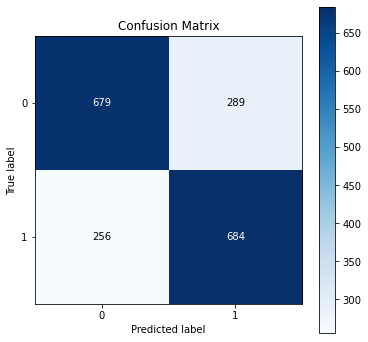

In [74]:
logisticRegr = LogisticRegression(solver='liblinear')
logisticRegr.fit(X_train, Y_train)

lreg_pred = logisticRegr.predict(X_test)

lreg_score = logisticRegr.score(X_test, Y_test)
lreg_precision = metrics.precision_score(Y_test, lreg_pred)
lreg_recall = metrics.recall_score(Y_test, lreg_pred)

print("Regressão Logística")
print("Acurácia:", lreg_score)
print("Precisão:", lreg_precision)
print("Recall:", lreg_recall)

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    lreg_pred,
    figsize=(6,6));

### 3.2 SVM

SVM
Acurácia: 0.7851153039832285
Precisão: 0.7623762376237624
Recall: 0.8191489361702128


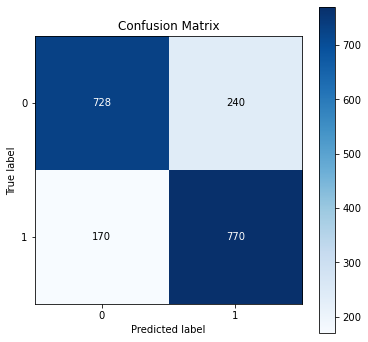

In [75]:
C=1e3; class_weight=None      ; gamma='auto'

svm_clf = svm.SVC(C=C, 
                  class_weight=class_weight, 
                  gamma=gamma).fit(X_train, Y_train)

svm_pred = svm_clf.predict(X_test)

svm_score = svm_clf.score(X_test, Y_test)
svm_precision = metrics.precision_score(Y_test, svm_pred)
svm_recall = metrics.recall_score(Y_test, svm_pred)

print("SVM")
print("Acurácia:", svm_score)
print("Precisão:", svm_precision)
print("Recall:", svm_recall)

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    svm_pred,
    figsize=(6,6));

### 3.3 Random Forest

Random Forest
Acurácia: 0.810272536687631
Precisão: 0.8196902654867256
Recall: 0.7882978723404256


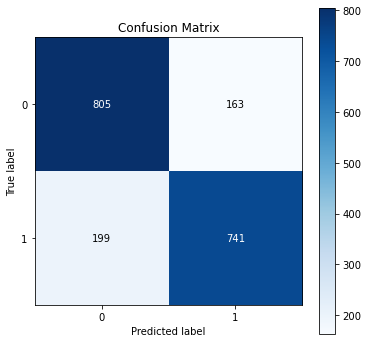

In [76]:
max_features='auto'; n_estimators=500; warm_start=True

rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                max_features=max_features,
                                warm_start=warm_start).fit(X_train, Y_train)

rf_pred = rf_clf.predict(X_test)

rf_score = rf_clf.score(X_test, Y_test)
rf_precision = metrics.precision_score(Y_test, rf_pred)
rf_recall = metrics.recall_score(Y_test, rf_pred)

print("Random Forest")
print("Acurácia:", rf_score)
print("Precisão:", rf_precision)
print("Recall:", rf_recall)

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    rf_pred,
    figsize=(6,6));

### 3.4 k-NN

KNN
Acurácia: 0.7311320754716981
Precisão: 0.727854855923159
Recall: 0.725531914893617


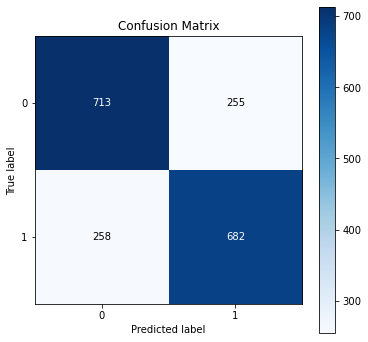

In [77]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, Y_train)

knn_pred = knn.predict(X_test)

knn_score = metrics.accuracy_score(Y_test, knn_pred)
knn_precision = metrics.precision_score(Y_test, knn_pred)
knn_recall = metrics.recall_score(Y_test, knn_pred)

print("KNN")
print("Acurácia:", knn_score)
print("Precisão:", knn_precision)
print("Recall:", knn_recall)

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    knn_pred,
    figsize=(6,6));

## 4. Cross-validation

Regressão Logística
Acurácia: 0.7190775681341719
Precisão: 0.7006302521008403
Recall: 0.7265795206971678


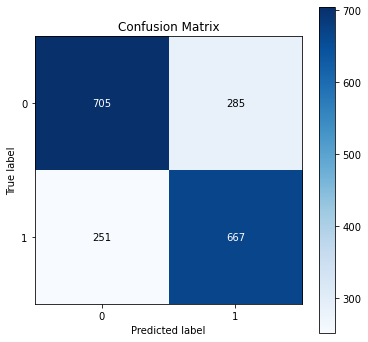

In [91]:
#Logistic Regression
LR_grid = {
           'C'                : [1e-3, .01, .1, 1, 10, 100, 1e3],                   #default = 1
           'class_weight'     : ['balanced', None],                                 #default = None (alternative: dict {class_label: weight})
           'solver'           : ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), #default = 'lbfgs'
          }                             

LR_search = GridSearchCV(LogisticRegression(max_iter = 1e4), LR_grid)
LR_search.fit(X_train, Y_train)
LR_clf = LR_search.best_estimator_
LR_pred = LR_clf.predict(X_test)
LR_acc = LR_search.score(X_test, Y_test)
LR_pre = metrics.precision_score(Y_test, LR_pred)
LR_rec = metrics.recall_score(Y_test, LR_pred)

print("Regressão Logística")
print("Acurácia:", LR_acc)
print("Precisão:", LR_pre)
print("Recall:", LR_rec)

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    LR_pred,
    figsize=(6,6));

SVM
Acurácia: 0.7840670859538784
Precisão: 0.7703252032520326
Recall: 0.8029661016949152


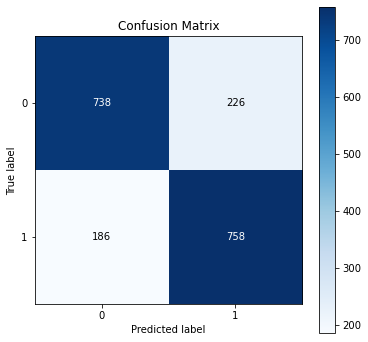

In [368]:
#SVM
SVM_grid = {
             'C'                       : [10, 100, 500, 1e3, 5e3, 1e4]      #default = 1        
            ,'gamma'                   : ['auto', .1, .3, .5, .7, .9]       #default = 'scale' 
            ,'class_weight'            : ['balanced', None]                 #default = None    
            }

SVM_search = GridSearchCV(svm.SVC(), SVM_grid)
SVM_search.fit(X_train, Y_train)
SVM_clf =  SVM_search.best_estimator_
SVM_pred = SVM_clf.predict(X_test)
SVM_acc =  SVM_search.score(X_test, Y_test)
SVM_pre = metrics.precision_score(Y_test, SVM_pred)
SVM_rec = metrics.recall_score(Y_test,    SVM_pred)

print("SVM")
print("Acurácia:", SVM_acc)
print("Precisão:", SVM_pre)
print("Recall:",   SVM_rec)

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    SVM_pred,
    figsize=(6,6));

Random Forest
Acurácia: 0.8134171907756813
Precisão: 0.8197611292073833
Recall: 0.798941798941799


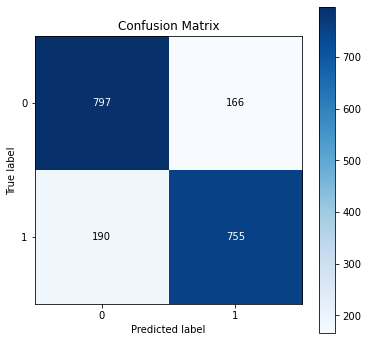

In [366]:
#Random Forest
RF_grid = {
             'n_estimators'             : [100, 300, 500]                     #default = 100     
            ,'max_features'             : ['auto', 'log2']                    #default = 'auto' 
            ,'warm_start'               : [True, False]                       #default = False
            }

RF_search = GridSearchCV(RandomForestClassifier(), RF_grid)
RF_search.fit(X_train, Y_train)
RF_clf =  RF_search.best_estimator_
RF_pred = RF_clf.predict(X_test)
RF_acc =  RF_search.score(X_test, Y_test)
RF_pre = metrics.precision_score(Y_test, RF_pred)
RF_rec = metrics.recall_score(Y_test,    RF_pred)

print("Random Forest")
print("Acurácia:", RF_acc)
print("Precisão:", RF_pre)
print("Recall:",   RF_rec)

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    RF_pred,
    figsize=(6,6));

k-NN
Acurácia: 0.7510482180293501
Precisão: 0.7741530740276035
Recall: 0.6765350877192983


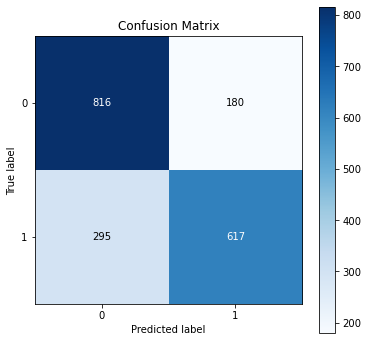

In [81]:
#k-NN
kNN_grid = {
             'n_neighbors' : [3, 5, 10, 50]              #default = 5
            ,'weights'     : ['uniform', 'distance']                   #default = 'uniform'
            ,'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'] #default = 'auto'
            ,'leaf_size'   : [3, 30, 300]                         #default = 30
            ,'p'           : [1, 2]                          #default = 2
            ,'metric'      : ['euclidean', 
                              'manhattan', 
                              'minkowski']                           #default = 'minkowski'
            #,'n_jobs'      : [None, -1, 2, 5]                          #default = None
            }

kNN_search = GridSearchCV(KNeighborsClassifier(), kNN_grid)
kNN_search.fit(X_train, Y_train)
kNN_clf =  kNN_search.best_estimator_
kNN_pred = kNN_clf.predict(X_test)
kNN_acc =  kNN_search.score(X_test, Y_test)
kNN_pre = metrics.precision_score(Y_test, kNN_pred)
kNN_rec = metrics.recall_score(Y_test,    kNN_pred)

print("k-NN")
print("Acurácia:", kNN_acc)
print("Precisão:", kNN_pre)
print("Recall:",   kNN_rec)

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    kNN_pred,
    figsize=(6,6));

SVM
Acurácia: 0.7756813417190775
Precisão: 0.7522477522477522
Recall: 0.8070739549839229


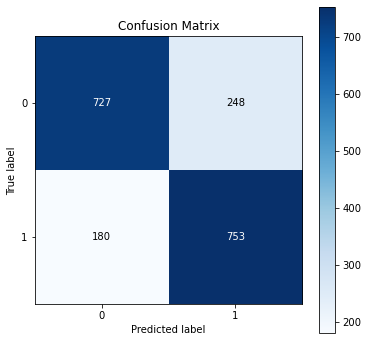

In [138]:
svm_clf = svm.SVC(C=5e3, gamma='auto').fit(X_train, Y_train)

svm_pred = svm_clf.predict(X_test)

svm_score = svm_clf.score(X_test, Y_test)
svm_precision = metrics.precision_score(Y_test, svm_pred)
svm_recall = metrics.recall_score(Y_test, svm_pred)

print("SVM")
print("Acurácia:", svm_score)
print("Precisão:", svm_precision)
print("Recall:", svm_recall)

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    svm_pred,
    figsize=(6,6));

In [369]:
print('Best combination of parameters using Random Forest:\n',
RF_search.cv_results_['params'][np.where(RF_search.cv_results_['rank_test_score']==1)[0][0]],'\n',
RF_search.cv_results_['params'][np.where(RF_search.cv_results_['rank_test_score']==2)[0][0]],'\n',
RF_search.cv_results_['params'][np.where(RF_search.cv_results_['rank_test_score']==3)[0][0]],'\n',
RF_search.cv_results_['params'][np.where(RF_search.cv_results_['rank_test_score']==4)[0][0]],'\n',
RF_search.cv_results_['params'][np.where(RF_search.cv_results_['rank_test_score']==5)[0][0]]
)

{'max_features': 'auto', 'n_estimators': 500, 'warm_start': True} 
 {'max_features': 'log2', 'n_estimators': 500, 'warm_start': True} 
 {'max_features': 'auto', 'n_estimators': 300, 'warm_start': True} 
 {'max_features': 'log2', 'n_estimators': 300, 'warm_start': False} 
 {'max_features': 'auto', 'n_estimators': 500, 'warm_start': False}


In [370]:
print('Best combination of parameters using SVM:\n',
SVM_search.cv_results_['params'][np.where(SVM_search.cv_results_['rank_test_score']==1)[0][0]],'\n',
SVM_search.cv_results_['params'][np.where(SVM_search.cv_results_['rank_test_score']==2)[0][0]],'\n',
SVM_search.cv_results_['params'][np.where(SVM_search.cv_results_['rank_test_score']==3)[0][0]],'\n',
SVM_search.cv_results_['params'][np.where(SVM_search.cv_results_['rank_test_score']==4)[0][0]],'\n',
SVM_search.cv_results_['params'][np.where(SVM_search.cv_results_['rank_test_score']==5)[0][0]]
)

{'C': 1000.0, 'class_weight': None, 'gamma': 'auto'} 
 {'C': 1000.0, 'class_weight': 'balanced', 'gamma': 'auto'} 
 {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1} 
 {'C': 10, 'class_weight': None, 'gamma': 0.1} 
 {'C': 10, 'class_weight': None, 'gamma': 0.3}


Random Forest
Acurácia: 0.8144654088050315
Precisão: 0.8143322475570033
Recall: 0.8038585209003215


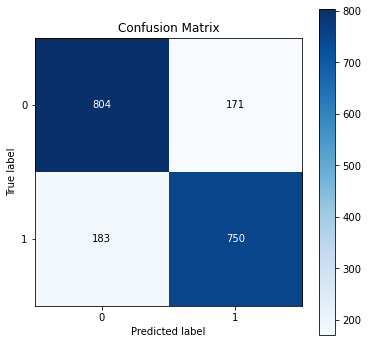

In [226]:
rf_clf = RandomForestClassifier(n_estimators=128, max_features='log2').fit(X_train, Y_train)

rf_pred = rf_clf.predict(X_test)

rf_score = rf_clf.score(X_test, Y_test)
rf_precision = metrics.precision_score(Y_test, rf_pred)
rf_recall = metrics.recall_score(Y_test, rf_pred)

print("Random Forest")
print("Acurácia:", rf_score)
print("Precisão:", rf_precision)
print("Recall:", rf_recall)

skplt.metrics.plot_confusion_matrix(
    Y_test, 
    rf_pred,
    figsize=(6,6));